In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import expm, eigh
import os
%matplotlib widget

# Atomic Unit Conversion
au_time = 2.4188843265864e-2 # fs
hartree_energy = 27.211386245981 # eV
au_time_conversion = 1 / au_time # from fs to au_time
au_energy_conversion = 1 / hartree_energy # from eV to au_energy

os.chdir('/asap3/flash/gpfs/fl26/2023/data/11015602/shared/Harijyoti/')
os.getcwd()

def C_t(t, t_min, t_max, delta_T):
    return np.where(
        t < t_min - delta_T, 0,
        np.where(t < t_min, np.sin((t - (t_min - delta_T)) * (np.pi / (2 * delta_T))) ** 2,
        np.where(t <= t_max, 1,
        np.where(t <= t_max + delta_T, np.cos((t - t_max) * (np.pi / (2 * delta_T))) ** 2, 0))))

# Function for E_omega (fundamental frequency)
def E_omega(t, E0, omega, t0, tau, phi_w):
    envelope = np.exp(-((t - t0) / tau) ** 2)
    oscillation_w = np.cos(omega * t + phi_w)
    return (E0 * envelope * oscillation_w )* C_t(t, t_min, t_max, delta_T)


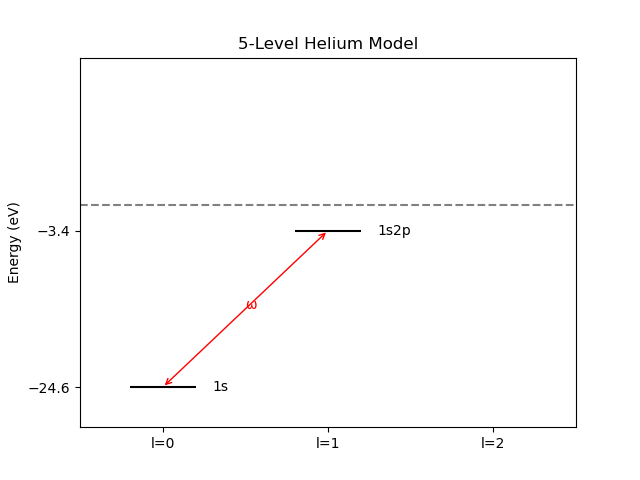

In [130]:
# Define energy levels (in eV)
energy_levels = {
    '1s': -24.6,
    '1s2p': -3.4
}



# Energies and dipole elements
omega_s_eV = energy_levels['1s']
omega_p_eV = energy_levels['1s2p']

# Convert energies from eV to atomic units
omega_s = omega_s_eV * au_energy_conversion
omega_p = omega_p_eV * au_energy_conversion
# Print converted energies for verification
# print(f"omega_s: {omega_s} au")
# print(f"omega_p: {omega_p} au")
# print(f"omega_es: {omega_es} au")
# print(f"omega_ep: {omega_ep} au")
# print(f"omega_ed: {omega_ed} au")


# Define x-axis positions for the levels
x_positions = {
    '1s': 0,
    '1s2p': 1
}

# Define transitions (start and end points)
transitions = [
    ('1s', '1s2p', '\u03C9', 'red'),
]

# Create the plot
fig, ax = plt.subplots()

# Plot energy levels
for level, energy in energy_levels.items():
    ax.hlines(energy, xmin=x_positions[level] - 0.2, xmax=x_positions[level] + 0.2, color='black')
    ax.text(x_positions[level] + 0.3, energy, level, verticalalignment='center')

# Plot transitions
for start, end, label, color in transitions:
    ax.annotate('', xy=(x_positions[end], energy_levels[end]), xytext=(x_positions[start], energy_levels[start]),
                arrowprops=dict(arrowstyle='<->', color=color))
    ax.text((x_positions[start] + x_positions[end]) / 2, (energy_levels[start] + energy_levels[end]) / 2, label, color=color)

ax.axhline(y=0, color='gray', linestyle='--', label='Zero Energy')

# Set plot limits and labels
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-30, 20)
ax.set_ylabel('Energy (eV)')
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['l=0', 'l=1', 'l=2'])
ax.set_yticks(list(energy_levels.values()))
ax.set_title('5-Level Helium Model')

# Show the plot
plt.show()

Time Step is 0.4 attoseconds


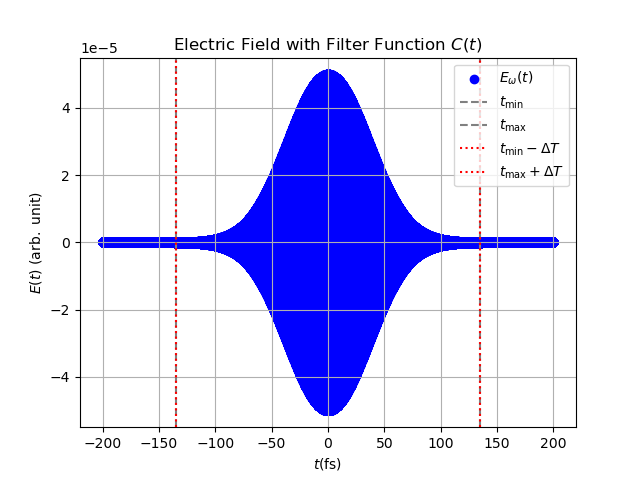

In [131]:
# Time array(in fs)
start_time, stop_time = -200,200  # fs
steps = 1000000  # steps
t_values_SI = np.linspace(start_time, stop_time, steps)  # Time array in femtoseconds
dt_SI = t_values_SI[1]- t_values_SI[0]
print(f'Time Step is {np.round(dt_SI*1000, decimals =2)} attoseconds')
t_values = t_values_SI *au_time_conversion  # Time array in atomic units
# Time step
dt = t_values[1] - t_values[0]
# Electric Field parameters
phi_w = 0.0
phi_2w = 0.0
tau = 50  # fs
tau_au = tau * au_time_conversion
t0 = 0 # fs  # setting t0 to a non-zero value to avoid zero limit issue
t0_au = t0 * au_time_conversion
E0_au = 0.00005
E02_au = 0.00005
omega = 21.2*au_energy_conversion

# Markers and annotations
t_min = -(tau-5)*au_time_conversion*3
t_max = (tau-5)*au_time_conversion*3
delta_T = dt*10

E_om = E_omega(t_values, E0_au, omega, t0_au, tau_au, phi_w)

plt.figure()
plt.scatter(t_values_SI, E_om, label='$E_{\omega}(t)$', color='b')
plt.axvline(t_min*au_time, linestyle='--', color='gray', label='$t_{\min}$')
plt.axvline(t_max*au_time, linestyle='--', color='gray', label='$t_{\max}$')
plt.axvline((t_min - delta_T)*au_time, linestyle=':', color='red', label='$t_{\min} - \Delta T$')
plt.axvline((t_max + delta_T)*au_time, linestyle=':', color='red', label='$t_{\max} + \Delta T$')
plt.xlabel('$t (\mathrm{fs})$')
plt.ylabel('$E(t) \ (\mathrm{arb.\ unit})$')
plt.title('Electric Field with Filter Function $C(t)$')
plt.legend()
plt.grid()
plt.show()

In [132]:
# Initial Hamiltonian without the field
H0 = np.array([
    [omega_s, 0],
    [0, omega_p],
], dtype=complex)

# Hamiltonian function
def dipole_matrix(d_ped, d_pes, d_sep, d_sp):
    return np.array([
        [0, d_sp],
        [d_sp, 0]
    ], dtype=complex)

In [133]:

# Define dipole matrix elements
# d_pes, d_sep, d_ped = 0.001, 0.0002, 0.0015
d_sp = 0.42

# Calculate dipole matrix element
dme = dipole_matrix(d_ped, d_pes, d_sep, d_sp)
# Diagonalize the dipole matrix
dme_eigenvalues, dme_eigenvectors = eigh(dme)
Diagonal_dme = np.diag(dme_eigenvalues)
#Reconstruct the original dipole matrix using its eigenvalues and eigenvectors
reconstructed_dme = np.dot(dme_eigenvectors, np.dot(Diagonal_dme, dme_eigenvectors.T.conj()))

print("Original dipole matrix (dme):")
print(dme)
print("\nEigenvalues of the dipole matrix:")
print(dme_eigenvalues)
print("\nEigenvectors of the dipole matrix:")
print(dme_eigenvectors)
print("\nReconstructed dipole matrix:")
print(reconstructed_dme)

# # Check if the reconstructed matrix is close to the original matrix
# if np.allclose(dme, reconstructed_dme):
#     print("\nThe reconstructed matrix is close to the original matrix.")
# else:
#     print("\nThere is a discrepancy between the original and reconstructed matrices.")

Original dipole matrix (dme):
[[0.  +0.j 0.42+0.j]
 [0.42+0.j 0.  +0.j]]

Eigenvalues of the dipole matrix:
[-0.42  0.42]

Eigenvectors of the dipole matrix:
[[-0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j  0.70710678+0.j]]

Reconstructed dipole matrix:
[[7.208116e-18+0.j 4.200000e-01+0.j]
 [4.200000e-01+0.j 7.208116e-18+0.j]]


In [134]:
expm(-1j *0* Diagonal_dme * dt)

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

In [135]:

def tdse_solver(omega_ev):
    omega_au = omega_ev*au_energy_conversion
    #E_om = E_omega(t_values, E0_au, omega_au, t0_au, tau_au, phi_w)
    dfs = {} # DataFrames for the all the populations at each time step
    # Initial state
    #psi_0 = np.array([1, 0, 0, 0, 0], dtype=complex)
    psi_0 = np.array([1, 0], dtype=complex)
    psi_t_list = [psi_0]
    U0_half_dt = expm(-1j * H0 * dt / 2)
    for index in range(len(t_values[1:])):
        t = t_values[index]
        #print(f"Time step {index}: t = {t} au")
        # Calculate the electric field at time t
        EF = E_omega(t, E0_au, omega_au, t0_au, tau_au, phi_w)
        #print(f"Electric field at t = {t} au: {EF}")
        psi_dt = psi_t_list[index]
        #print(f"psi_dt: {psi_dt}")
        psi_0_u0 = np.dot(U0_half_dt, psi_dt)
        #print(f"psi_0_u0: {psi_0_u0}")
        psi_0_eigenbasis = np.dot(dme_eigenvectors.T.conj(), psi_0_u0)
        u_t = expm(-1j *EF* Diagonal_dme * dt )
        #print(f"u_t: {u_t}")
        psi_t_eigenbasis = np.dot(u_t, psi_0_eigenbasis)
        #print(f"psi_t_eigenbasis: {psi_t_eigenbasis}")
        psi_t_pre = np.dot(dme_eigenvectors, psi_t_eigenbasis)
        #print(f"psi_t_pre: {psi_t_pre}")
        psi_t_u0 = np.dot(U0_half_dt, psi_t_pre)
        # Check for NaN values
        if np.isnan(psi_t_u0).any():
            print(f"NaN detected at time step {index}, EF: {EF}")
            print(f"Intermediate values at time step {index}:")
            print(f"psi_0_u0: {psi_0_u0}")
            print(f"psi_0_eigenbasis: {psi_0_eigenbasis}")
            print(f"u_t: {u_t}")
            print(f"psi_t_eigenbasis: {psi_t_eigenbasis}")
            print(f"psi_t_pre: {psi_t_pre}")
            break
        psi_t_list.append(psi_t_u0)
    psi_t_array = np.array(psi_t_list)
    dfs[f'df_psi_{round(omega_ev,4)}'] = pd.DataFrame(psi_t_array, columns=['s', 'p'])
    return dfs

In [136]:
omega_ev = 21.2
print(f"Running simulation for omega = {round(omega_ev, 3)} eV")
dfs = tdse_solver(omega_ev)
print(f"Completed simulation for omega = {round(omega_ev, 3)} eV")

Running simulation for omega = 21.2 eV
Completed simulation for omega = 21.2 eV


In [137]:
np.abs(dfs['df_psi_21.2']['s'])**2

0         1.000000
1         1.000000
2         1.000000
3         1.000000
4         1.000000
            ...   
999995    0.998521
999996    0.998521
999997    0.998521
999998    0.998521
999999    0.998521
Name: s, Length: 1000000, dtype: float64

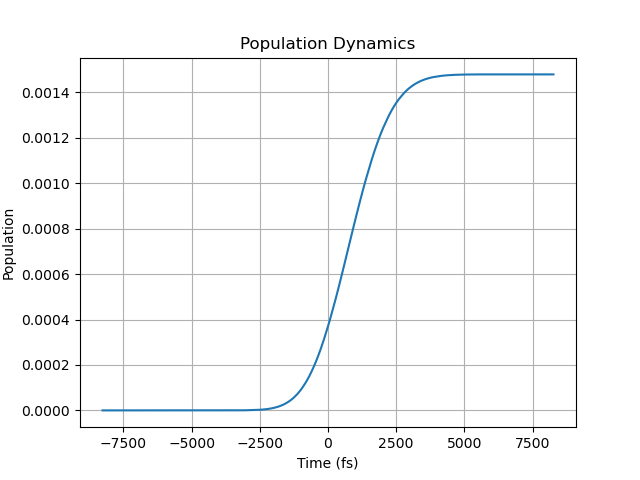

In [138]:
plt.figure()
#plt.plot(np.abs(dfs['df_psi_21.2']['s'])**2)
plt.plot(t_values,np.abs(dfs['df_psi_21.2']['p'])**2)
plt.xlabel('Time (fs)')
plt.ylabel('Population')
# plt.axhline(y=0, color='gray', linestyle='--', label='Zero Population')
# plt.axvline(t_min*au_time, linestyle='--', color='gray', label='$t_{\min}$')
# plt.axvline(t_max*au_time, linestyle='--', color='gray', label='$t_{\max}$')
# plt.axvline((t_min - delta_T)*au_time, linestyle=':', color='red', label='$t_{\min} - \Delta T$')
# plt.axvline((t_max + delta_T)*au_time, linestyle=':', color='red', label='$t_{\max} + \Delta T$')
plt.title('Population Dynamics')
plt.grid()
plt.show()

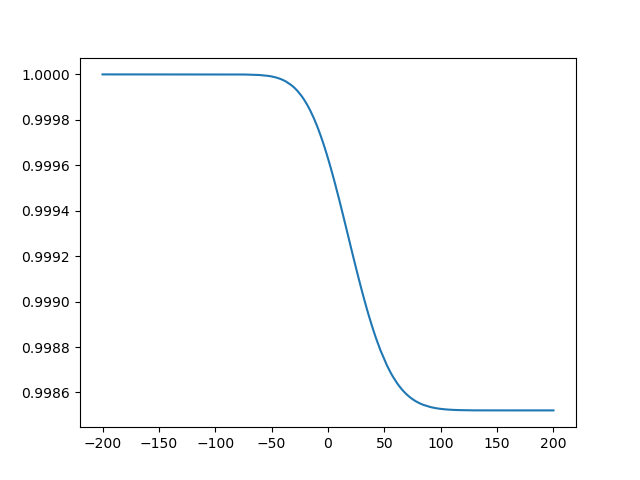

In [139]:
plt.figure()
plt.plot(t_values_SI,np.abs(dfs['df_psi_21.2']['s'])**2)
#plt.plot(t_values_SI,np.abs(dfs['df_psi_21.2']['p'])**2)
#plt.scatter(t_values, E_field/1e7, label='$E_{\omega}(t)$', color='r')
#plt.plot(t_values_SI, np.abs(dfs['df_psi_21.2']['es'])**2, label = 'es')
#plt.plot(t_values_SI, np.abs(dfs['df_psi_21.2']['ep'])**2, label = 'ep')
#plt.plot(t_values_SI, np.abs(dfs['df_psi_21.2']['ed'])**2, label = 'ed')

#plt.legend()
plt.show()

In [140]:
# Running simulations for a range of omega values
steps_eV = 0.001
omega_values = np.round(np.arange(21.1, 21.3, steps_eV), 3)
results_dfs = {}
results_dfp = {}

# Create output directory if it does not exist
output_dir = f'simulation_results_optimisized_{tau}fs_V4.2'
os.makedirs(output_dir, exist_ok=True)

for omega_ev in omega_values:
    print(f"Running simulation for omega = {round(omega_ev, 3)} eV")
    dfs1, dfp1 = tdse_solver(omega_ev)
    dfs1[f'df_psi_{omega_ev}'].to_csv(os.path.join(output_dir, f'psi_t_stepseV_{steps_eV}_{round(omega_ev, 3)}_d_sep_{d_sep}_d_pes{d_pes}_d_ped_{d_ped}.csv'), index=False)
    dfp1[f'df_pop_{omega_ev}'].to_csv(os.path.join(output_dir, f'pop_t_stepseV_{steps_eV}_{round(omega_ev, 3)}_d_sep_{d_sep}_d_pes{d_pes}_d_ped_{d_ped}.csv'), index=False)
    results_dfs.update(dfs1)
    results_dfp.update(dfp1)
    print(f"Completed simulation for omega = {round(omega_ev, 3)} eV")

# Save dictionary objects
results_dfs_path = os.path.join(output_dir, f"results_dfs_stepseV_{steps_eV}_d_sep_{d_sep}_d_pes{d_pes}_d_ped_{d_ped}.pkl")
results_dfp_path = os.path.join(output_dir, f"results_dfp_stepseV_{steps_eV}_d_sep_{d_sep}_d_pes{d_pes}_d_ped_{d_ped}.pkl")

pd.to_pickle(results_dfs, results_dfs_path)
pd.to_pickle(results_dfp, results_dfp_path)

print(f"All simulations completed and results saved to {output_dir}")

Running simulation for omega = 21.1 eV


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
populations = []
populationp = []
populationes = []
populationep = []
populationed = []
iloc_val = indices[- 1]
for omega_ev in omega_values:
    #print(omega_ev)
    df = results_dfp[f'df_pop_{omega_ev}']
    populations.append(df['s'].iloc[iloc_val])
    populationp.append(df['p'].iloc[iloc_val])
    populationes.append(df['es'].iloc[iloc_val])
    populationep.append(df['ep'].iloc[iloc_val])
    populationed.append(df['ed'].iloc[iloc_val])    
    

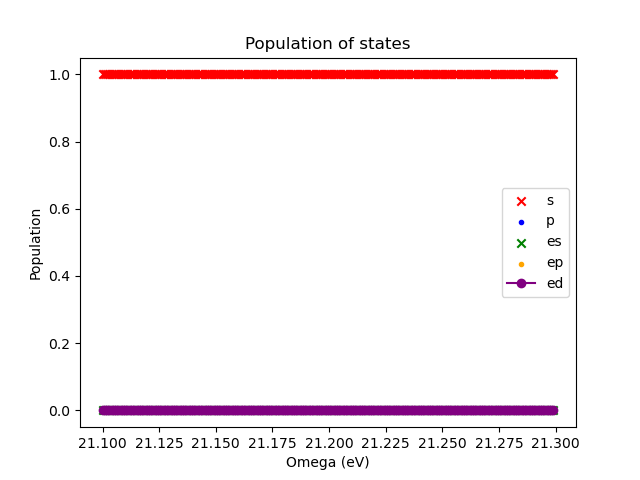

In [ ]:
#populations = np.array(populations).astype(int)
plt.figure()
plt.scatter(omega_values, populations, marker='x', label='s' , color='red')
plt.scatter(omega_values, populationp, marker='.', label='p', color='blue')
plt.scatter(omega_values, populationes, marker='x', label='es', color='green')
plt.scatter(omega_values, populationep, marker='.', label='ep', color='orange')
plt.plot(omega_values, populationed, label='ed', marker='o', color='purple')
plt.title('Population of states')
plt.xlabel('Omega (eV)')
plt.ylabel('Population')
#plt.legend(['s', 'p', 'es', 'pes', 'ed'])
#plt.legend(['es', 'ep', 'ed'])
plt.legend()
#plt.xlim(21.09, 21.2)
#plt.ylim(0, 3e-17)
plt.show()

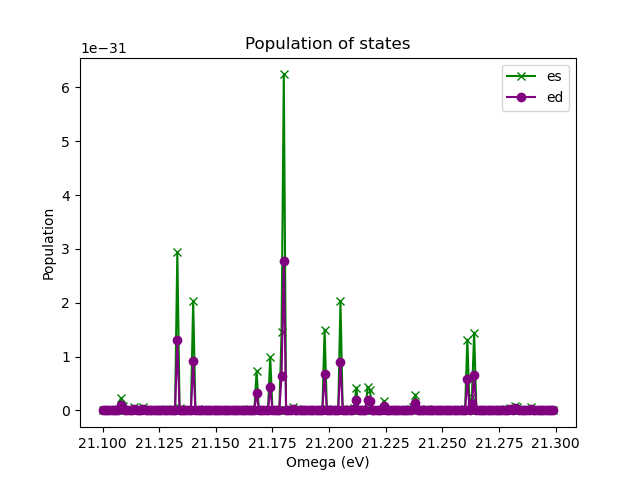

In [ ]:
#populations = np.array(populations).astype(int)
plt.figure()
#plt.scatter(omega_values, populations, marker='x', label='s' , color='red')
#plt.scatter(omega_values, populationp, marker='.', label='p', color='blue')
plt.plot(omega_values, populationes, marker='x', label='es', color='green')
#plt.plot(omega_values, populationep, marker='.', label='ep', color='orange')
plt.plot(omega_values, populationed, label='ed', marker='o', color='purple')
#plt.axvline(x=Ecooper, color='brown', linestyle='--', label='Cooper Minimum')
#plt.axvline(x=Eres, color='black', linestyle='--', label='Resonance')
plt.title('Population of states')
plt.xlabel('Omega (eV)')
plt.ylabel('Population')
plt.legend()
#plt.xlim(21.09, 21.35)
#plt.ylim(0, 3e-17)
plt.show()
#plt.close()

## Compare with Chris Green values

In [ ]:
data=np.loadtxt('c_phi_spd_40_45 (no phase jumps).dat',skiprows=1)
data[1294:2874,2]=-data[1294:2874,2]
data[1294:1564,6]=-data[1294:1564,6]

In [ ]:
Ew= E0_au
E2w= E02_au

DeltaPhi=0

omega=data[:,1]/2
c0=data[:,2]*Ew**2
c1=data[:,4]*E2w
c2=data[:,6]*Ew**2
phi0=data[:,3]
phi1=data[:,5]
phi2=data[:,7]

Wtot=c0**2 + c1**2 + c2**2
beta1=(2*np.sqrt(3)*c0*c1*np.cos(DeltaPhi-(phi0-phi1))
      +(4/np.sqrt(3))*c1*c2*np.cos(DeltaPhi-(phi2-phi1)))/Wtot
beta2=(2*c1**2 + (10/7)*c2**2 + 2*np.sqrt(5)*c0*c2*np.cos(phi2-phi0))/Wtot
beta3=((6/np.sqrt(3))*c1*c2*np.cos(DeltaPhi-(phi2-phi1)))/Wtot
beta4=((18/7)*c2**2)/Wtot

Ecooper=(-c2[1563]/(c2[1564]-c2[1563]))*(omega[1564]-omega[1563])+omega[1563]
Eres=21.216174

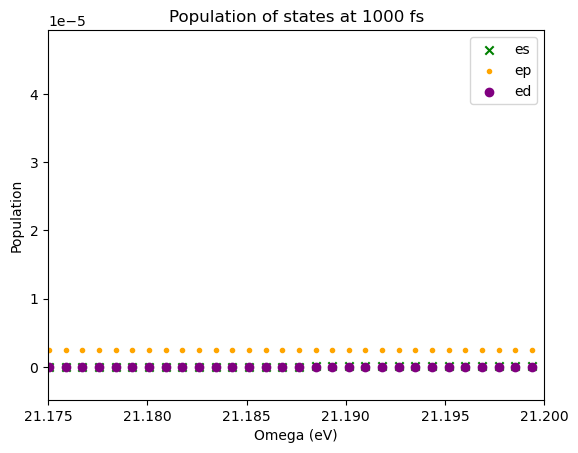

In [ ]:
%matplotlib inline
plt.scatter(omega, c0, marker='x', label='es', color='green')
plt.scatter(omega, c1, marker='.', label='ep', color='orange')
plt.scatter(omega, c2, label='ed', marker='o', color='purple')
plt.title('Population of states at 1000 fs')
plt.xlabel('Omega (eV)')
plt.ylabel('Population')
#plt.legend(['s', 'p', 'es', 'pes', 'ed'])
#plt.legend(['es', 'ep', 'ed'])
plt.legend()
plt.xlim(21.175, 21.2)
plt.show()

In [ ]:
%matplotlib widget

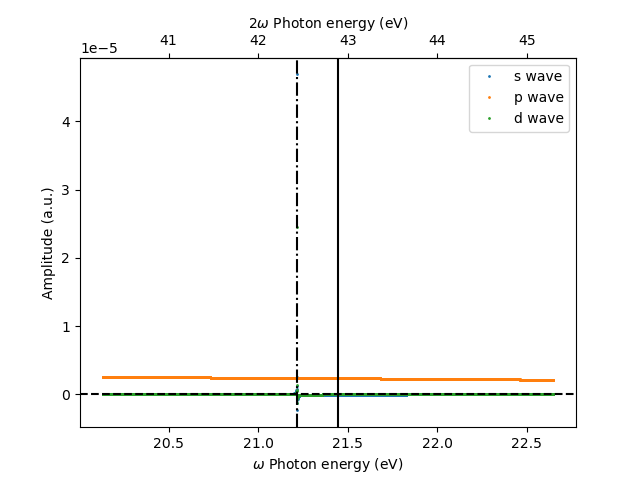

In [ ]:
fig,ax = plt.subplots()
ax.plot(omega,c0,'.',label='s wave',markersize=2)
ax.plot(omega,c1,'.',label='p wave',markersize=2)
ax.plot(omega,c2,'.',label='d wave',markersize=2)
ax.axvline(x=Ecooper,color='black')
ax.axvline(x=Eres,color='black',ls='dashdot')
ax.axhline(y=0,color='black',ls='--')
#plt.yscale('symlog')
ax.set_xlabel(r'$\omega$ Photon energy (eV)')
ax.set_ylabel('Amplitude (a.u.)')
#ax.set_xlim(21.2161,21.2162)
#ax.set_ylim(-0.02,0.02)
plt.legend()
ax2=ax.secondary_xaxis('top',functions=(lambda x:x*2, lambda x:x/2))
ax2.set_xlabel(r'2$\omega$ Photon energy (eV)')
plt.show()
#plt.close()